# Proximity Forest
> Ik was Bart Goethals tegengekomen dit weekend en we hadden het toevallig over dit project.
Hij had me aangeraden dat we eens naar proximity forests moesten kijken:
https://link.springer.com/article/10.1007/s10618-019-00617-3

An implementation can be found [here](https://github.com/moradabaz/ProximityForests-python).


In [ ]:
import tcrdist.repertoire
!pip install Pforests-dtw

I installed it, but it addes a lot of imports not linked to each other (e.g. trees, core, datastructures, ...), will probably clash somewhere with other libraries.

In [17]:
from trees import ProximityForest
from core import FileReader
import random

train_dataset = FileReader.FileReader.load_arff_data("data/planes/Plane_TRAIN.arff")
test_dataset = FileReader.FileReader.load_arff_data("data/planes/Plane_TEST.arff")

Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5)
Pforest.train(train_dataset)
results = Pforest.test(test_dataset)
print(results.accuracy)

FICHERO: <_io.TextIOWrapper name='data/planes/Plane_TRAIN.arff' mode='r' encoding='cp1252'>
Reading File: [ data/planes/Plane_TRAIN.arff ]
finished in 0.008998394012451172 seconds
FICHERO: <_io.TextIOWrapper name='data/planes/Plane_TEST.arff' mode='r' encoding='cp1252'>
Reading File: [ data/planes/Plane_TEST.arff ]
finished in 0.009997844696044922 seconds
Training dataStructures ...


100%|██████████| 100/100 [00:03<00:00, 31.14it/s]



0.9714285714285714


In [26]:
# This only allows some specific formats, let's see if we can change our data to a supported format
from util import get_train_dataset, get_test_dataset

train_df = get_train_dataset()
# train_df = train_df.sample(100)
train_df.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
0,NaN,NaN,NaN,CSARDGSGARSNQPQHF,TRBV20-1,TRBJ1-5,0,NaN,NaN,NaN,NaN,TRBV20,1.0,TRBJ1,5.0
1,NaN,NaN,NaN,CASSSGTGTSEQYF,TRBV5-1,TRBJ2-7,0,NaN,NaN,NaN,NaN,TRBV5,1.0,TRBJ2,7.0
2,CAFMKQRGGGADGLTF,TRAV38-1,TRAJ45,CASSISSGRGNEQFF,TRBV19,TRBJ2-1,0,TRAJ45,1.0,TRAV38,1,TRBV19,1.0,TRBJ2,1.0
3,CRNAGGTSYGKLTF,TRAV25,TRAJ52,CASSSHQRTGVDEQFF,TRBV27,TRBJ2-1,1,TRAJ52,1.0,TRAV25,1,TRBV27,1.0,TRBJ2,1.0
4,NaN,NaN,NaN,CASSPGPSGGLTYEQYF,TRBV5-4,TRBJ2-7,0,NaN,NaN,NaN,NaN,TRBV5,4.0,TRBJ2,7.0


In [27]:
# Split into train and validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [28]:
# Dropping for testing Todo remove
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)

In [29]:
# Convert to features
from util import get_features
import numpy as np

train_features = get_features(train_df)
val_features = get_features(val_df, test=True)
train_label = train_df['reaction']

# add nan labels to features (so we can drop them together)
val_features.reset_index(drop=True, inplace=True)
val_label = val_df['reaction'].reset_index(drop=True)
assert len(val_features) == len(val_label)
val_features['reaction'] = val_label

# remove nan rows from val_features
val_count = len(val_features)
val_features = val_features.dropna()
val_count = val_count - val_features.shape[0]
print(f"Removed {val_count} rows from validation set ({val_count / val_df.shape[0] * 100:.2f}%)")

train_features.head()

Removed 0 rows from validation set (0.00%)


,beta_J=TRBJ1-1,beta_J=TRBJ1-2,beta_J=TRBJ1-3,beta_J=TRBJ1-4,beta_J=TRBJ1-5,beta_J=TRBJ1-6,beta_J=TRBJ2-1,beta_J=TRBJ2-2,beta_J=TRBJ2-3,beta_J=TRBJ2-4,...,alfa_pos_-8_pI,alfa_pos_8_pI,alfa_pos_-9_pI,alfa_pos_9_pI,alfa_pos_-11_pI,alfa_pos_-10_pI,alfa_pos_10_pI,alfa_pos_11_pI,alfa_pos_-12_pI,alfa_pos_12_pI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# lets modify their readCSVToListDataset function to support reading from a dataframe
from dataStructures import ListDataset
import pandas as pd
import time


def readDataframeToListDataset(features_df, labels_df=None, label_col_name=None):
    """"
    Read a pandas dataframe to a ListDataset
    :param features_df: pandas dataframe with features (and labels if labels_df is None)
    :param labels_df: pandas dataframe with labels
    :param label_col_name: name of the column with the labels (if labels_df is None)
    :return: ListDataset
    """

    if labels_df is None:
        assert label_col_name is not None, "label_col_name must be specified if labels_df is None"
        labels_df = features_df[label_col_name]
        features_df = features_df.drop(label_col_name, axis=1)

    assert len(features_df) == len(labels_df), "features_df and labels_df must have the same length"
    assert np.isnan(labels_df).sum() == 0, "NaN values in labels_df"

    df = features_df.reset_index(drop=True)
    assert 'target' not in df.columns, "'target' column already exists in features_df. Please rename it or specify using label_col_name."
    df['target'] = labels_df.reset_index(drop=True)

    start = time.time()
    dataset = ListDataset.ListDataset()

    for index, row in df.iterrows():
        series = row.values[:-1]
        label = row.values[-1]
        if label not in [0, 1]:
            raise ValueError("Label must be 0 or 1")
        assert not np.isnan(label), "Label cannot be NaN"
        dataset.add_series(label, series)

    end = time.time()
    elapsed = end - start
    print(f"Parsing process finished in {elapsed} seconds")

    return dataset

In [31]:
train_dataset = readDataframeToListDataset(train_features, labels_df=train_label)
val_dataset = readDataframeToListDataset(val_features, label_col_name='reaction')

Parsing process finished in 0.1159982681274414 seconds
Parsing process finished in 0.02702808380126953 seconds


In [37]:
% % time
Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5)  #todo: 100  trees
Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)

Training dataStructures ...


100%|██████████| 100/100 [20:49<00:00, 12.49s/it]



0.5855855855855856
Wall time: 30min 40s


In [38]:
results.print_results(dataset_name="GILGFVFTIL (train nans removed)", experiment_id=1, prefix="")

Training time: 1249.0095235 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=20, tm_sec=49, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 390 incorrect(FP+FN) 276
Accuracy: 0.5855855855855856
REPEAT: 2 , GILGFVFTIL (train nans removed)
, accuracy 0.5855855855855856
, elapsed time train 0.0012490095234999998
, elapsed time test 0.0005913592830000002
, mean depth tree 20.52



### 2 trees
Training time: 24.733337300000017 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=0, tm_sec=24, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 300 incorrect(FP+FN) 366
Accuracy: 0.45045045045045046
REPEAT: 2 , GILGFVFTIL (train nans removed)
, accuracy 0.45045045045045046
, elapsed time train 2.4733337300000015e-05
, elapsed time test 1.2283185199999934e-05
, mean depth tree 20.5

### 100 trees
Training time: 1249.0095235 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=20, tm_sec=49, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 390 incorrect(FP+FN) 276
Accuracy: 0.5855855855855856
REPEAT: 2 , GILGFVFTIL (train nans removed)
, accuracy 0.5855855855855856
, elapsed time train 0.0012490095234999998
, elapsed time test 0.0005913592830000002
, mean depth tree 20.52

Quite deep in both scenario's (might cause overfitting). Let's try setting the max_depth to 3.

In [39]:
% % time
Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5, max_depth=3)
Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)

Training dataStructures ...


100%|██████████| 100/100 [20:31<00:00, 12.32s/it]



0.5855855855855856
Wall time: 30min 28s


In [40]:
results.print_results(dataset_name="GILGFVFTIL (train nans removed)", experiment_id=1, prefix="")

Training time: 1231.8500225999996 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=20, tm_sec=31, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 390 incorrect(FP+FN) 276
Accuracy: 0.5855855855855856
REPEAT: 2 , GILGFVFTIL (train nans removed)
, accuracy 0.5855855855855856
, elapsed time train 0.0012318500225999996
, elapsed time test 0.0005964720342000001
, mean depth tree 20.52



The max_depth didn't work, the mean depth is still 20.5. Probably some bug in the code.

## Zero substitution
Keeping the train nans resulted in an infinitly-seeming long training time, which is why I dropped them. Let's try again  with changing them to zeros this time.

In [42]:
% % time
from util import get_train_dataset, get_features
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np

# from util import readDataframeToListDataset

df = get_train_dataset()
# df = df.sample(100)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

val_df.dropna(inplace=True)

train_features = get_features(train_df)
val_features = get_features(val_df, test=True)
train_label = train_df['reaction']
val_label = val_df['reaction']

# impute train_features with 0 and convert to a pandas dataframe again
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
train_features = pd.DataFrame(imp.fit_transform(train_features), columns=train_features.columns)

train_dataset = readDataframeToListDataset(train_features, labels_df=train_label)
val_dataset = readDataframeToListDataset(val_features, labels_df=val_label)

Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5)  #todo: 100  trees
Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)
results.print_results(dataset_name="GILGFVFTIL (train nans removed)", experiment_id=1, prefix="")

Parsing process finished in 0.26200342178344727 seconds
Parsing process finished in 0.025998830795288086 seconds
Training dataStructures ...


100%|██████████| 100/100 [1:16:29<00:00, 45.89s/it]



0.6186186186186187
Training time: 4589.3693422 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=2, tm_min=16, tm_sec=29, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 412 incorrect(FP+FN) 254
Accuracy: 0.6186186186186187
REPEAT: 2 , GILGFVFTIL (train nans removed)
, accuracy 0.6186186186186187
, elapsed time train 0.0045893693421999995
, elapsed time test 0.0013432581885999989
, mean depth tree 24.55

Wall time: 1h 39min 1s


Training time: 4589.3693422 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=2, tm_min=16, tm_sec=29, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 412 incorrect(FP+FN) 254
Accuracy: 0.6186186186186187
REPEAT: 2 , GILGFVFTIL (train nans removed)
, accuracy 0.6186186186186187
, elapsed time train 0.0045893693421999995
, elapsed time test 0.0013432581885999989
, mean depth tree 24.55

Wall time: 1h 39min 1s

 al beginnen schrijven

Proximity trees distance measure: TCR dist 3
Traag, eventueel gewoon hamming distance op CDR3; V en J ook in rekening houden

NaN: ofwel  geen verschil, ofwel  een half puntje? Half  puntje gaat te zwaar bestraffen; niet met KNN, wel proximity trees
Nan + aminozuur = volledige match

## Other distance function
Up to now, I used the distance on the featurs. However, we can also immediately apply some kind of distance measure on the amino acid sequence. Let's try that.


In [1]:
from util import get_train_dataset, get_test_dataset

train_df = get_train_dataset()
train_df = train_df.sample(100)
train_df.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
3469,CAGPYNQGGKLIF,TRAV12-2,TRAJ23,CASSIRSTETQYF,TRBV19,TRBJ2-5,1,TRAJ23,1.0,TRAV12,2,TRBV19,1.0,TRBJ2,5.0
5530,CAGGGSQGNLIF,TRAV27,TRAJ42,CASSIRASYEQYF,TRBV19,TRBJ2-7,1,TRAJ42,1.0,TRAV27,1,TRBV19,1.0,TRBJ2,7.0
2333,NaN,NaN,NaN,CASSLALAGTDTQYF,TRBV12-3,TRBJ2-3,1,NaN,NaN,NaN,NaN,TRBV12,3.0,TRBJ2,3.0
2225,NaN,NaN,NaN,CASRHQGQENTEAFF,TRBV7-9,TRBJ1-1,0,NaN,NaN,NaN,NaN,TRBV7,9.0,TRBJ1,1.0
5986,NaN,NaN,NaN,CASSYNTEAFF,TRBV6-6,TRBJ1-1,1,NaN,NaN,NaN,NaN,TRBV6,6.0,TRBJ1,1.0


In [4]:
# start with only the CDR3 sequences (we might add TRAV/J later (as one feature that can differ (while the CDR3 alfa can differ per character))
from util import get_columns_starting_with
import pandas as pd

cdr3s = get_columns_starting_with(train_df, 'CDR3')
reactions = train_df['reaction']
combined = pd.concat([cdr3s, reactions], axis=1)
combined.head()

,CDR3_alfa,CDR3_beta,reaction
3469,CAGPYNQGGKLIF,CASSIRSTETQYF,1
5530,CAGGGSQGNLIF,CASSIRASYEQYF,1
2333,NaN,CASSLALAGTDTQYF,1
2225,NaN,CASRHQGQENTEAFF,0
5986,NaN,CASSYNTEAFF,1


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


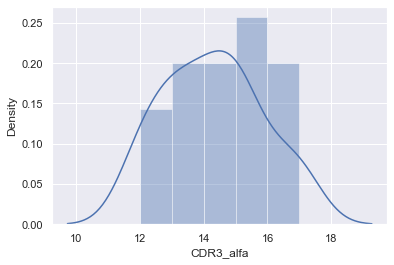

In [5]:
# get CDR3_alfa length distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.distplot(combined['CDR3_alfa'].str.len())
plt.show()

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


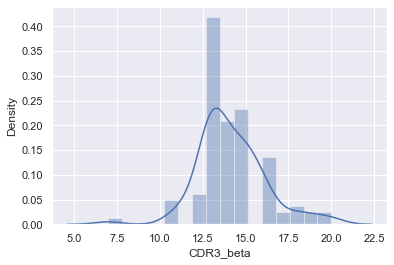

In [6]:
# get CDR3_beta length distribution
sns.distplot(combined['CDR3_beta'].str.len())
plt.show()

In [15]:
import numpy as np


# create a new distance fucntion that takes the CDR3_alfa and CDR3_beta into account
def distance_cdr3s(cdr3_alfa, cdr3_beta, cdr3_alfa_other, cdr3_beta_other):
    return distance_cdr3(cdr3_alfa, cdr3_alfa_other) + distance_cdr3(cdr3_beta, cdr3_beta_other)


def needleman_wunsch(x, y, match=1, mismatch=1, gap=1):
    # Implementation from https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:, 0] = np.linspace(0, -nx * gap, nx + 1)
    F[0, :] = np.linspace(0, -ny * gap, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:, 0] = 3
    P[0, :] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i, j] + match
            else:
                t[0] = F[i, j] - mismatch
            t[1] = F[i, j + 1] - gap
            t[2] = F[i + 1, j] - gap
            tmax = np.max(t)
            F[i + 1, j + 1] = tmax
            if t[0] == tmax:
                P[i + 1, j + 1] += 2
            if t[1] == tmax:
                P[i + 1, j + 1] += 3
            if t[2] == tmax:
                P[i + 1, j + 1] += 4

    return tmax

    """
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return '\n'.join([rx, ry])
    """


def distance_cdr3(cdr3, cdr3_other):
    # if any is NaN, see it as a perfect match
    if pd.isna(cdr3) or pd.isna(cdr3_other):
        return 1
    # get the distance between the two amino acid sequences (using sequence alignment)
    nw_score = needleman_wunsch(cdr3, cdr3_other)
    # distance, so lower means closer, let's change that
    return 1 / nw_score if nw_score != 0 else 0

In [16]:
needleman_wunsch('GILGFVFTIL', 'GILGFVFTIL')

10.0

In [17]:
# changed first letter
needleman_wunsch('GILGFVFTIL', 'LILGFVFTIL')

8.0

In [18]:
# removed last letter on both sides
needleman_wunsch('GILGFVFTI', 'GILGFVFTI')

9.0

In [19]:
# removed last letter on 2nd string
needleman_wunsch('GILGFVFTIL', 'GILGFVFTI')

8.0

Currently longer strings have a higher score, which makes sense, since they are more similar then (contain more similar characters)



## TCR dist
Up to now, I tried implementing my own distance function. However, TCR dist might also give good results.
https://tcrdist3.readthedocs.io/en/latest/



In [ ]:
# install tcrdist3
!pip install tcrdist3
!  #pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
# gives problems installing fisher wheel, also tried with --user flag
# might be because I removed visual studio (and thus c++ compiler) some time ago, reinstall it from here https://visualstudio.microsoft.com/visual-cpp-build-tools/
# I still got the 2017 version, upgrading to 2022
# didn't work, more info on the exception here: https://stackoverflow.com/questions/40018405/cannot-open-include-file-io-h-no-such-file-or-directory
# installing windows 11sdk, this fixed indeed the issue

In [1]:
# Sample code used in the tcrdist docs
import pandas as pd
from tcrdist.repertoire import TCRrep

df = pd.read_csv("dash.csv")
tr = TCRrep(cell_df=df,
            organism='mouse',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            compute_distances=False)

FileNotFoundError: [Errno 2] No such file or directory: 'dash.csv'

dash.csv can be found on the tcrdist github repo: https://github.com/kmayerb/tcrdist3/blob/master/dash.csv. It contains the following columns:
subject, epitope, count,
v_a_gene, j_a_gene, cdr3_a_aa, cdr3_a_nucseq,
v_b_gene, j_b_gene, cdr3_b_aa, cdr3_b_nucseq,
clone_id

alphabeta_gammadelta_db.tsv should be included in the repo. Let's try with (a subset of) our data:

In [18]:
from util import get_train_dataset

train_dataset = get_train_dataset()
train_dataset = train_dataset.dropna()
train_dataset = train_dataset[:100]
train_dataset.head(3)

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
2,CAFMKQRGGGADGLTF,TRAV38-1,TRAJ45,CASSISSGRGNEQFF,TRBV19,TRBJ2-1,0,TRAJ45,1.0,TRAV38,1,TRBV19,1.0,TRBJ2,1.0
3,CRNAGGTSYGKLTF,TRAV25,TRAJ52,CASSSHQRTGVDEQFF,TRBV27,TRBJ2-1,1,TRAJ52,1.0,TRAV25,1,TRBV27,1.0,TRBJ2,1.0
12,CAGASNTGKLIF,TRAV27,TRAJ37,CASSLGDNTEAFF,TRBV7-9,TRBJ1-1,1,TRAJ37,1.0,TRAV27,1,TRBV7,9.0,TRBJ1,1.0


In [19]:
from tcrdist.repertoire import TCRrep

tr = TCRrep(cell_df=train_dataset,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            compute_distances=True)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a column called 'cdr3_a_aa' to track the CDR3 amino acid sequence

  self._validate_cell_df()
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a column called 'v_a_gene' for default functions

  self._validate_cell_df()
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a column calle

AttributeError: 'DataFrame' object has no attribute 'v_a_gene'

In [20]:
# print our columns
print(train_dataset.columns)

Index(['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ', 'reaction',
       'TRAJ_family', 'TRAJ_version', 'TRAV_family', 'TRAV_version',
       'TRBV_family', 'TRBV_version', 'TRBJ_family', 'TRBJ_version', 'count'],
      dtype='object')


column names seem to mather, lets rename our columns. Our columns are the following:
CDR3_alfa, TRAV, TRAJ,
CDR3_beta, TRBV, TRBJ
reaction

In [21]:
column_rename_map = {
    'CDR3_alfa': 'cdr3_a_aa',
    'CDR3_beta': 'cdr3_b_aa',
    'TRAV': 'v_a_gene',
    'TRAJ': 'j_a_gene',
    'TRBV': 'v_b_gene',
    'TRBJ': 'j_b_gene'
}

In [22]:
train_dataset = train_dataset.rename(columns=column_rename_map)
train_dataset = train_dataset[column_rename_map.values()]
train_dataset.head(3)

,cdr3_a_aa,cdr3_b_aa,v_a_gene,j_a_gene,v_b_gene,j_b_gene
2,CAFMKQRGGGADGLTF,CASSISSGRGNEQFF,TRAV38-1,TRAJ45,TRBV19,TRBJ2-1
3,CRNAGGTSYGKLTF,CASSSHQRTGVDEQFF,TRAV25,TRAJ52,TRBV27,TRBJ2-1
12,CAGASNTGKLIF,CASSLGDNTEAFF,TRAV27,TRAJ37,TRBV7-9,TRBJ1-1


In [23]:
tr = TCRrep(cell_df=train_dataset,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            compute_distances=True)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV38-1 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV25 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-

ValueError: zero-size array to reduction operation maximum which has no identity

In [24]:
# remove the nans, since they might cause the error above
train_dataset = train_dataset.dropna()

In [25]:
tr = TCRrep(cell_df=train_dataset,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            compute_distances=False)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV38-1 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV25 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV27 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV6 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\

In [26]:
# import tcrdist
tr.show_incomplete()
# tr._show_incomplete()

,cdr3_a_aa,cdr3_b_aa,v_a_gene,j_a_gene,v_b_gene,j_b_gene,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,cdr3_a_aa,cdr3_b_aa
2,CAFMKQRGGGADGLTF,CASSISSGRGNEQFF,TRAV38-1,TRAJ45,TRBV19,TRBJ2-1,None,None,None,None,None,None,CAFMKQRGGGADGLTF,CASSISSGRGNEQFF
3,CRNAGGTSYGKLTF,CASSSHQRTGVDEQFF,TRAV25,TRAJ52,TRBV27,TRBJ2-1,None,None,None,None,None,None,CRNAGGTSYGKLTF,CASSSHQRTGVDEQFF
12,CAGASNTGKLIF,CASSLGDNTEAFF,TRAV27,TRAJ37,TRBV7-9,TRBJ1-1,None,None,None,None,None,None,CAGASNTGKLIF,CASSLGDNTEAFF
13,CALDNVWDSGYALNF,CASSLVPIGTDTQYF,TRAV6,TRAJ41,TRBV12-3,TRBJ2-3,None,None,None,None,None,None,CALDNVWDSGYALNF,CASSLVPIGTDTQYF
14,CAYRSARIGTASKLTF,CASRRIGRGGNQPQHF,TRAV38-2DV8,TRAJ44,TRBV19,TRBJ1-5,None,None,None,None,None,None,CAYRSARIGTASKLTF,CASRRIGRGGNQPQHF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,CIVRVAATNARLMF,CASSLGVRGYDEKLFF,TRAV26-1,TRAJ31,TRBV7-8,TRBJ1-4,None,None,None,None,None,None,CIVRVAATNARLMF,CASSLGVRGYDEKLFF
219,CALTGNYGQNFVF,CASSIRSSYEQYF,TRAV16,TRAJ26,TRBV19,TRBJ2-7,None,None,None,None,None,None,CALTGNYGQNFVF,CASSIRSSYEQYF
221,CAFMTNAGGTSYGKLTF,CASSQGSYGYTF,TRAV38-1,TRAJ52,TRBV19,TRBJ1-2,None,None,None,None,None,None,CAFMTNAGGTSYGKLTF,CASSQGSYGYTF
226,CAENTRAGNTPLVF,CASSPSSYKDNEQFF,TRAV5,TRAJ29,TRBV9,TRBJ2-1,None,None,None,None,None,None,CAENTRAGNTPLVF,CASSPSSYKDNEQFF


Not all cells/sequences could be grouped into clones. 100 of 100 were not captured. This occurs when any of the values in the index columns are null or missing for a given sequence. To see entries with missing values use: tcrdist.repertoire.TCRrep._show_incomplete()

The count column seems important, let's assign it to 1 everywhere:

In [30]:
train_dataset['count'] = 0

In [31]:
tr = TCRrep(cell_df=train_dataset,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            compute_distances=False)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV38-1 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV25 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV27 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV6 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\

In [32]:
tr.show_incomplete()

,cdr3_a_aa,cdr3_b_aa,v_a_gene,j_a_gene,v_b_gene,j_b_gene,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,cdr3_a_aa,cdr3_b_aa
2,CAFMKQRGGGADGLTF,CASSISSGRGNEQFF,TRAV38-1,TRAJ45,TRBV19,TRBJ2-1,None,None,None,None,None,None,CAFMKQRGGGADGLTF,CASSISSGRGNEQFF
3,CRNAGGTSYGKLTF,CASSSHQRTGVDEQFF,TRAV25,TRAJ52,TRBV27,TRBJ2-1,None,None,None,None,None,None,CRNAGGTSYGKLTF,CASSSHQRTGVDEQFF
12,CAGASNTGKLIF,CASSLGDNTEAFF,TRAV27,TRAJ37,TRBV7-9,TRBJ1-1,None,None,None,None,None,None,CAGASNTGKLIF,CASSLGDNTEAFF
13,CALDNVWDSGYALNF,CASSLVPIGTDTQYF,TRAV6,TRAJ41,TRBV12-3,TRBJ2-3,None,None,None,None,None,None,CALDNVWDSGYALNF,CASSLVPIGTDTQYF
14,CAYRSARIGTASKLTF,CASRRIGRGGNQPQHF,TRAV38-2DV8,TRAJ44,TRBV19,TRBJ1-5,None,None,None,None,None,None,CAYRSARIGTASKLTF,CASRRIGRGGNQPQHF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,CIVRVAATNARLMF,CASSLGVRGYDEKLFF,TRAV26-1,TRAJ31,TRBV7-8,TRBJ1-4,None,None,None,None,None,None,CIVRVAATNARLMF,CASSLGVRGYDEKLFF
219,CALTGNYGQNFVF,CASSIRSSYEQYF,TRAV16,TRAJ26,TRBV19,TRBJ2-7,None,None,None,None,None,None,CALTGNYGQNFVF,CASSIRSSYEQYF
221,CAFMTNAGGTSYGKLTF,CASSQGSYGYTF,TRAV38-1,TRAJ52,TRBV19,TRBJ1-2,None,None,None,None,None,None,CAFMTNAGGTSYGKLTF,CASSQGSYGYTF
226,CAENTRAGNTPLVF,CASSPSSYKDNEQFF,TRAV5,TRAJ29,TRBV9,TRBJ2-1,None,None,None,None,None,None,CAENTRAGNTPLVF,CASSPSSYKDNEQFF


I can't get the library working, let's try implementing the tcrdist3 algorithm myself based on their implementation. This are code fragments of their implementation:

```python
def compute_distances(self, df = None):
    if df is None:
        df = self.clone_df
    if 'alpha' in self.chains:
        pw_alpha  = _pws(
            df = df,
            metrics = self.metrics_a,
            weights = self.weights_a,
            kargs   = self.kargs_a,
            cpu     = self.cpus,
            store   = self.store_all_cdr)
        self._assign_distance_attributes(d = pw_alpha, chain = 'alpha')
    if 'beta' in self.chains:
        # continues like this for all chains
        pass
```

_pws performs pairwise distance calculation across a multiple
    columns of a Pandas DataFrame.

Sample values for the different parameters:

```python
def _initialize_chain_specific_attributes(self):
    """
    Initialize pw object and default substitution matrix (smat) based on
    chains arguments.

    Naming of all objects have a standardized order
        region_chain_molecular_object
        (cdr3)_(a|b|d|g)_(aa|p)_(pw|smat|hmat)

    """
    if "alpha" in self.chains:
        self.cdr3_a_aa_smat = 'blosum62'
        self.cdr2_a_aa_smat = 'blosum62'
        self.cdr1_a_aa_smat = 'blosum62'
        self.pmhc_a_aa_smat = 'blosum62'
        self.index_cols.append("cdr3_a_aa")
        self.metrics_a = {
            "cdr3_a_aa" : pw.metrics.nb_vector_tcrdist,
            "pmhc_a_aa" : pw.metrics.nb_vector_tcrdist,
            "cdr2_a_aa" : pw.metrics.nb_vector_tcrdist,
            "cdr1_a_aa" : pw.metrics.nb_vector_tcrdist }
        self.weights_a = {
            "cdr3_a_aa" : 3,
            "pmhc_a_aa" : 1,
            "cdr2_a_aa" : 1,
            "cdr1_a_aa" : 1}
        self.kargs_a = {
            "cdr3_a_aa" : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':4, 'ntrim':3, 'ctrim':2, 'fixed_gappos':False},
            "pmhc_a_aa" : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':4, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True},
            "cdr2_a_aa" : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':4, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True},
            "cdr1_a_aa" : {'use_numba': True, 'distance_matrix': pw.matrices.tcr_nb_distance_matrix, 'dist_weight': 1, 'gap_penalty':4, 'ntrim':0, 'ctrim':0, 'fixed_gappos':True}}

```

THe nb_vector_tcrdist function is defined as follows:
```python
def nb_vector_tcrdist(indices, seqs_mat, seqs_L, distance_matrix=tcr_nb_distance_matrix, dist_weight=3, gap_penalty=4, ntrim=3, ctrim=2, fixed_gappos=True):
    """Computes the tcrdist distance for sequences in seqs_mat indicated by pairs of indices.

    Note: to use with non-CDR3 sequences set ntrim and ctrim to 0.

    Note: this function is a wrapper of the numba function so that default arguments, and passing of
    keyword arguments is supported.

    Parameters
    ----------
    indices : np.ndarray [nseqs, 2]
        Indices into seqs_mat indicating pairs of sequences to compare.
    seqs_mat : np.ndarray dtype=int16 [nseqs, seq_length]
        Created by pwsd.seqs2mat with padding to accomodate
        sequences of different lengths (-1 padding)
    seqs_L : np.ndarray [nseqs]
        A vector containing the length of each sequence,
        without the padding in seqs_mat
    distance_matrix : np.ndarray [alphabet, alphabet] dtype=int32
        A square distance matrix (NOT a similarity matrix).
        Matrix must match the alphabet that was used to create
        seqs_mat, where each AA is represented by an index into the alphabet.
    dist_weight : int
        Weight applied to the mismatch distances before summing with the gap penalties
    gap_penalty : int
        Distance penalty for the difference in the length of the two sequences
    ntrim/ctrim : int
        Positions trimmed off the N-terminus (0) and C-terminus (L-1) ends of the peptide sequence. These symbols will be ignored
        in the distance calculation.
    fixed_gappos : bool
        If True, insert gaps at a fixed position after the cysteine residue statring the CDR3 (typically position 6).
        If False, find the "optimal" position for inserting the gaps to make up the difference in length

    Returns
    -------
    dists : np.ndarray, dtype=np.int16
        Vector of distances with length equal to indices.shape[0]"""

    return _nb_vector_tcrdist(indices, seqs_mat, seqs_L, distance_matrix, dist_weight, gap_penalty, ntrim, ctrim, fixed_gappos)
```

The _nb_vector_tcrdist function is defined as follows:
```python
@nb.jit(nopython=True, parallel=False, nogil=True)
def _nb_vector_tcrdist(indices, seqs_mat, seqs_L, distance_matrix=tcr_nb_distance_matrix, dist_weight=3, gap_penalty=4, ntrim=3, ctrim=2, fixed_gappos=True):
    """This function works OK on its own. Wrapping it with the above python function was a workaround because
    joblib and multiprocessing seem to have an issue retaining default arguments with numba functions."""
    assert seqs_mat.shape[0] == seqs_L.shape[0]

    dist = np.zeros(indices.shape[0], dtype=np.int16)
    for ind_i in nb.prange(indices.shape[0]):
        query_i = indices[ind_i, 0]
        seq_i = indices[ind_i, 1]
        q_L = seqs_L[query_i]
        s_L = seqs_L[seq_i]
        if q_L == s_L:
            """No gaps: substitution distance"""
            for i in range(ntrim, q_L - ctrim):
                dist[ind_i] += distance_matrix[seqs_mat[query_i, i], seqs_mat[seq_i, i]] * dist_weight
            continue

        short_len = min(q_L, s_L)
        len_diff = abs(q_L - s_L)
        if fixed_gappos:
            min_gappos = min(6, 3 + (short_len - 5) // 2)
            max_gappos = min_gappos
        else:
            min_gappos = 5
            max_gappos = short_len - 1 - 4
            while min_gappos > max_gappos:
                min_gappos -= 1
                max_gappos += 1
        min_dist = -1
        # min_count = -1
        for gappos in range(min_gappos, max_gappos + 1):
            tmp_dist = 0
            # tmp_count = 0
            remainder = short_len - gappos
            for n_i in range(ntrim, gappos):
                """n_i refers to position relative to N term"""
                # print (n_i, shortseq[i], longseq[i], distance_matrix[shortseq[i]+longseq[i]])
                tmp_dist += distance_matrix[seqs_mat[query_i, n_i], seqs_mat[seq_i, n_i]]
                # tmp_count += 1
            # print('sequence_distance_with_gappos1:', gappos, remainder, dist[seq_i])
            for c_i in range(ctrim, remainder):
                """c_i refers to position relative to C term, counting upwards from C term"""
                tmp_dist += distance_matrix[seqs_mat[query_i, q_L - 1 - c_i], seqs_mat[seq_i, s_L - 1 - c_i]]
                # tmp_count += 1
            # print('sequence_distance_with_gappos2:', gappos, remainder, dist[seq_i])
            if tmp_dist < min_dist or min_dist == -1:
                min_dist = tmp_dist
                # min_count = tmp_count
            if min_dist == 0:
                break
        dist[ind_i] = min_dist * dist_weight + len_diff * gap_penalty
    return dist
```

In [2]:
import pandas as pd
from tcrdist.repertoire import TCRrep

df = pd.read_csv("data/dash.csv").sample(100)
tr = TCRrep(cell_df=df,
            organism='mouse',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv',
            compute_distances=True)

KeyboardInterrupt: 

In [5]:
import pwseqdist as pwsd

# Found this piece of code in the unitttest that demonstrates how I can use the distance function
# (code modified to test more what I want)

seqs_dot = ['CACADLGAYPDKLIF',
            'CACDALLAYTDKLIF',
            'CACDAV...LDKLIF',
            'CACDDVTEVEGDKLIF',
            'CACDFISPSNWGIQSGRNTDKLIF']

seqs1 = ['CACADLGAYPDKLIF',
         'CACDALLAYTDKLIF',
         'CACDAV...LDKLIF', ]

seqs2 = ['CACDDVTEVEGDKLIF',
         'CACDALLAYTDKLIF']

# drect_dots2 = pwsd.apply_pairwise_rect(pwsd.metrics.nb_vector_tcrdist, seqs1=seqs_dot, seqs2=None, use_numba=True, ncpus=1, uniqify=False)
drect_dots2 = pwsd.apply_pairwise_rect(pwsd.metrics.nb_vector_tcrdist, seqs1=seqs1, seqs2=seqs2, use_numba=True,
                                       ncpus=1, uniqify=False)

drect_dots2

array([[73, 48],
       [73,  0],
       [28, 21]], dtype=int16)

In [13]:
def calculate_distances(seq1, seq2):
    drect_dots2 = pwsd.apply_pairwise_rect(pwsd.metrics.nb_vector_tcrdist, seqs1=[seq1], seqs2=[seq2], use_numba=True,
                                           ncpus=1, uniqify=False)
    return drect_dots2[0][0]

In [14]:
calculate_distances(seqs1[0], seqs2[0])

73

We got a distance function. Let's try to modify our ProximityTree class to use this function instead of the default one.

In [1]:
import sys

sys.path.append('Pforest-dtw')

from trees import ProximityForest
from core import FileReader
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_test_dataset
from dataStructures import ListDataset
import pandas as pd
import time
from util import readDataframeToListDataset

train_df = get_train_dataset()
# only keep the CDR3 columns
train_df = train_df[['CDR3_alfa', 'CDR3_beta', 'reaction']]
train_df.dropna(inplace=True)  # TODO: remove this, distance function should handle this
train_df = train_df.sample(100)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = readDataframeToListDataset(train_df, label_col_name='reaction')
val_dataset = readDataframeToListDataset(val_df, label_col_name='reaction')

Pforest = ProximityForest.ProximityForest(1, n_trees=3, n_candidates=5)  #todo: 100  trees instead of 3

Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Parsing process finished in 0.0030014514923095703 seconds
Parsing process finished in 0.0009992122650146484 seconds
Training dataStructures ...


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


0.65


Running  it in a seperate file to profile the time (and see which functions should be optimized using numba) resulted in this:

![](img/profile-dst.png)

![](img/profile-dst-own.png)

The distance measure is the most time consuming part. However, this function allows both a string and a float (since nan is a float), so we can't compile it with numba.

Tried optimizing it with numba, but that didn't work (problems with determining types). Also tried without nopython=True.

| type (3 trees, 1000 samples)                       | time (ms) |
|----------------------------------------------------|-----------|
| no-numba                                           | 55 945    |
| numba on dist (no nopython, incl compilation time) | 102 280   |
| with nopython                                      | error     |



In [1]:
import sys

sys.path.append('Pforest-dtw')

from trees import ProximityForest
from core import FileReader
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_test_dataset
from dataStructures import ListDataset
import pandas as pd
import time
from util import readDataframeToListDataset
from util import calculate_tcr_dist_multiple_chains

train_df = get_train_dataset()
# only keep the CDR3 columns
train_df = train_df[['CDR3_alfa', 'CDR3_beta', 'reaction']]
train_df = train_df.sample(100)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = readDataframeToListDataset(train_df, label_col_name='reaction')
val_dataset = readDataframeToListDataset(val_df, label_col_name='reaction')

Pforest = ProximityForest.ProximityForest(1, n_trees=3, n_candidates=5,
                                          distance_measure=calculate_tcr_dist_multiple_chains,
                                          distance_kwargs={"nan_distance": 5})  #todo: 100  trees instead of 3

Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)

results.print_results(dataset_name="GILGFVFTL", experiment_id=0, prefix="100 sample, 3 trees, 5 nan dist")

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Parsing process finished in 0.0029985904693603516 seconds
Parsing process finished in 0.001001119613647461 seconds
Training dataStructures ...


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


0.65
Training time: 2.5727142 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=0, tm_sec=2, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 13 incorrect(FP+FN) 7
Accuracy: 0.65
REPEAT: 1 , GILGFVFTL
, accuracy 0.65
, elapsed time train 2.5727142000000002e-06
, elapsed time test 8.595540000000046e-08
, mean depth tree 13.333333333333334



In [1]:
% % time
train_df = get_train_dataset()
# only keep the CDR3 columns
train_df = train_df[['CDR3_alfa', 'CDR3_beta', 'reaction']]
# train_df = train_df.sample(1000)
print(len(train_df))
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = readDataframeToListDataset(train_df, label_col_name='reaction')
val_dataset = readDataframeToListDataset(val_df, label_col_name='reaction')

Pforest = ProximityForest.ProximityForest(1, n_trees=3, n_candidates=5,
                                          distance_measure=calculate_tcr_dist_multiple_chains,
                                          distance_kwargs={"nan_distance": 5})  #todo: 100  trees instead of 3

Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)

NameError: name 'get_train_dataset' is not defined

In [ ]:
Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5,
                                          distance_measure=calculate_tcr_dist_multiple_chains,
                                          distance_kwargs={"nan_distance": 5})

Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
print(results.accuracy)

Training dataStructures ...


 63%|██████▎   | 63/100 [2:40:17<1:37:24, 157.97s/it]

In [2]:
import sys

sys.path.append('Pforest-dtw')

from trees import ProximityForest
from core import FileReader
from dataStructures import ListDataset

from sklearn.model_selection import train_test_split
import pandas as pd
import time

from util import get_train_dataset, get_test_dataset, readDataframeToListDataset, calculate_tcr_dist_multiple_chains

train_df = get_train_dataset()
# only keep the CDR3 columns
train_df = train_df[['CDR3_alfa', 'CDR3_beta', 'reaction']]
train_df = train_df.sample(2000)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = readDataframeToListDataset(train_df, label_col_name='reaction')
val_dataset = readDataframeToListDataset(val_df, label_col_name='reaction')

for nan_distance in [0, 60, 100]:
    Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5,
                                              distance_measure=calculate_tcr_dist_multiple_chains,
                                              distance_kwargs={"nan_distance": nan_distance})
    Pforest.train(train_dataset)
    results = Pforest.test(val_dataset)
    results.print_results(dataset_name=f"GILGFVFTL(s=1000,t=100,nd={nan_distance})", experiment_id=0,
                          prefix=f"Where is prefix used?")

Parsing process finished in 0.05699777603149414 seconds
Parsing process finished in 0.014034509658813477 seconds
Training dataStructures ...


100%|██████████| 100/100 [47:28<00:00, 28.49s/it]



Training time: 2848.6718551000004 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=47, tm_sec=28, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 250 incorrect(FP+FN) 150
Accuracy: 0.625
REPEAT: 1 , GILGFVFTL(s=1000,t=100,nd=0)
, accuracy 0.625
, elapsed time train 0.0028486718551000005
, elapsed time test 9.474145599999974e-05
, mean depth tree 26.61

Training dataStructures ...


100%|██████████| 100/100 [45:44<00:00, 27.45s/it]



Training time: 2744.547009 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=45, tm_sec=44, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 241 incorrect(FP+FN) 159
Accuracy: 0.6025
REPEAT: 1 , GILGFVFTL(s=1000,t=100,nd=60)
, accuracy 0.6025
, elapsed time train 0.002744547009
, elapsed time test 9.61162032000002e-05
, mean depth tree 22.89

Training dataStructures ...


100%|██████████| 100/100 [45:19<00:00, 27.20s/it]



Training time: 2719.7950766000004 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=45, tm_sec=19, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 240 incorrect(FP+FN) 160
Accuracy: 0.6
REPEAT: 1 , GILGFVFTL(s=1000,t=100,nd=100)
, accuracy 0.6
, elapsed time train 0.0027197950766000003
, elapsed time test 9.380284879999999e-05
, mean depth tree 22.82



Results remain bad. Let's create a small test case to see whether everything works as expected.

In [1]:
import sys

sys.path.append('Pforest-dtw')

from trees import ProximityForest
from core import FileReader
from dataStructures import ListDataset

from sklearn.model_selection import train_test_split
import pandas as pd
import time

from util import get_train_dataset, get_test_dataset, readDataframeToListDataset, calculate_tcr_dist_multiple_chains

train_df_list = [
    {
        "CDR3_alfa": "CACA",
        "CDR3_beta": "CASS",
        "reaction": 1
    },
    {
        "CDR3_alfa": "CAC",
        "CDR3_beta": "CASD",
        "reaction": 1
    },
    {
        "CDR3_alfa": "CLIF",
        "CDR3_beta": "TQYF",
        "reaction": 0
    }
]

val_df_list = [
    {
        "CDR3_alfa": "CASAA",
        "CDR3_beta": "CBSS",
        "reaction": 1
    },
    {
        "CDR3_alfa": "CAIF",
        "CDR3_beta": "TRYF",
        "reaction": 0
    }
]

train_df = pd.DataFrame(train_df_list)
val_df = pd.DataFrame(val_df_list)

train_dataset = readDataframeToListDataset(train_df, label_col_name='reaction')
val_dataset = readDataframeToListDataset(val_df, label_col_name='reaction')

nan_distance = 5

Pforest = ProximityForest.ProximityForest(1, n_trees=100, n_candidates=5,
                                          distance_measure=calculate_tcr_dist_multiple_chains,
                                          distance_kwargs={"nan_distance": nan_distance})
Pforest.train(train_dataset)
results = Pforest.test(val_dataset)
results.print_results(dataset_name=f"GILGFVFTL(s=1000,t=100,nd={nan_distance})", experiment_id=0,
                      prefix=f"Where is prefix used?")

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Parsing process finished in 0.0009548664093017578 seconds
Parsing process finished in 0.0 seconds
Training dataStructures ...


100%|██████████| 100/100 [00:00<00:00, 110.73it/s]



Training time: 0.9054193000000001 ( time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=1, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=1, tm_isdst=0) )
Correct(TP+TN): 1 incorrect(FP+FN) 1
Accuracy: 0.5
REPEAT: 1 , GILGFVFTL(s=1000,t=100,nd=5)
, accuracy 0.5
, elapsed time train 9.054193000000002e-07
, elapsed time test 1.2078830000000007e-07
, mean depth tree 2.6



Hmm, I would've expected the accuracy to be 100%.

## Own implementation
using the implementation from my earlier research project (since above library is too much focussed on time series, making it harder to understand).


In [2]:
from util import ProximityTreeClassifier, calculate_tcr_dist_multiple_chains

# create numpy arrays for the train and test data
train_X = train_df[['CDR3_alfa', 'CDR3_beta']].to_numpy()
train_y = train_df['reaction'].to_numpy()

val_X = val_df[['CDR3_alfa', 'CDR3_beta']].to_numpy()
val_y = val_df['reaction'].to_numpy()

model = ProximityTreeClassifier(distance_measure=calculate_tcr_dist_multiple_chains,
                                distance_kwargs={"nan_distance": 5})
model.fit(train_X, train_y)

In [3]:
model.print()

Exemplar (0): ['CLIF' 'TQYF']
-Exemplar (0): ['CLIF' 'TQYF']
--Exemplar (0): ['CLIF' 'TQYF']
---Exemplar (0): ['CLIF' 'TQYF']
----Exemplar (0): ['CLIF' 'TQYF']
-----Leaf (0)
Exemplar (1): ['CAC' 'CASD']
-Leaf (1)


In [4]:
model.predict(val_X)

Taking branch 0 after comparing ['CASAA' 'CBSS'] with ['CLIF' 'TQYF'] (d=4) and ['CAC' 'CASD'] (d=8)
Taking branch 0 after comparing ['CAIF' 'TRYF'] with ['CLIF' 'TQYF'] (d=0) and ['CAC' 'CASD'] (d=4)


array([0, 0], dtype=int64)

In [5]:
model.predict([['CLIFF', 'TQYF']])

Taking branch 0 after comparing ['CLIFF' 'TQYF'] with ['CLIF' 'TQYF'] (d=4) and ['CAC' 'CASD'] (d=8)


array([0], dtype=int64)

In [6]:
model.predict([['CAC', 'CASD']])

Taking branch 1 after comparing ['CAC' 'CASD'] with ['CLIF' 'TQYF'] (d=4) and ['CAC' 'CASD'] (d=0)


array([1], dtype=int64)

In [1]:
from util import get_train_dataset, ProximityTreeClassifier, calculate_tcr_dist_multiple_chains
from sklearn.model_selection import train_test_split

train_df = get_train_dataset()
# only keep the CDR3 columns
train_df = train_df[['CDR3_alfa', 'CDR3_beta', 'reaction']]
train_df = train_df.sample(100)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# create numpy arrays for the train and test data
train_X = train_df[['CDR3_alfa', 'CDR3_beta']].to_numpy()
train_y = train_df['reaction'].to_numpy()

val_X = val_df[['CDR3_alfa', 'CDR3_beta']].to_numpy()
val_y = val_df['reaction'].to_numpy()

model = ProximityTreeClassifier(distance_measure=calculate_tcr_dist_multiple_chains,
                                distance_kwargs={"nan_distance": 5})
model.fit(train_X, train_y)

model.print()

predictions = model.predict(val_X)

Exemplar (0): ['CAFMPHDQAGTALIF' 'CASSWTGQETQYF']
-Exemplar (0): [nan 'CASSLVGYQETQYF']
--Exemplar (0): [nan 'CASSFAVGIDTQYF']
---Leaf (0)
--Exemplar (1): [nan 'CASSQDLTFIKTQYF']
---Exemplar (0): [nan 'CASSLVGYQETQYF']
----Leaf (0)
---Exemplar (1): [nan 'CASSQDLTFIKTQYF']
----Exemplar (0): [nan 'CASSQVWLAGGPTQYF']
-----Leaf (0)
----Exemplar (1): [nan 'CASSQDLTFIKTQYF']
-----Leaf (0)
-Exemplar (1): ['CAFMKHEGMDSNYQLIW' 'CASSIHWGNTEAFF']
--Exemplar (0): [nan 'CASSPRTGGVGELFF']
---Leaf (0)
--Exemplar (1): ['CAFMKHEGMDSNYQLIW' 'CASSIHWGNTEAFF']
---Exemplar (0): [nan 'CASSSSGTGFHEQYF']
----Leaf (0)
---Exemplar (1): [nan 'CASSYGTGMNEQFF']
----Exemplar (0): [nan 'CASSPGRLNYGYTF']
-----Leaf (0)
----Exemplar (1): [nan 'CASSYGTGMNEQFF']
-----Leaf (1)
Exemplar (1): ['CAGSHGGSQGNLIF' 'CASSIRSTDTQYF']
-Exemplar (0): [nan 'CVSSISWFPVIVVYTF']
--Exemplar (0): ['CAVHSSGAGSYQLTF' 'CASKESGGATYEQYF']
---Exemplar (0): ['CAMRELISGYSTLTF' 'CAWSYGGDTYEQYF']
----Leaf (0)
---Exemplar (1): ['CAARTGNQFYF' 'CASRRD

In [2]:
from sklearn.metrics import accuracy_score

accuracy_score(val_y, predictions)

0.65

In [4]:
from util import get_train_dataset, ProximityTreeClassifier, calculate_tcr_dist_multiple_chains
from sklearn.model_selection import train_test_split

train_df = get_train_dataset()
# only keep the CDR3 columns
train_df = train_df[['CDR3_alfa', 'CDR3_beta', 'reaction']]
# train_df = train_df.sample(100)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# create numpy arrays for the train and test data
train_X = train_df[['CDR3_alfa', 'CDR3_beta']].to_numpy()
train_y = train_df['reaction'].to_numpy()

val_X = val_df[['CDR3_alfa', 'CDR3_beta']].to_numpy()
val_y = val_df['reaction'].to_numpy()

In [5]:
from util import ProximityForestClassifier
from sklearn.metrics import accuracy_score

model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains,
                                  distance_kwargs={"nan_distance": 5})
model.fit(train_X, train_y)

predictions = model.predict(val_X)

accuracy_score(val_y, predictions)

Predicting: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


0.7322503008423586

Predicting: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


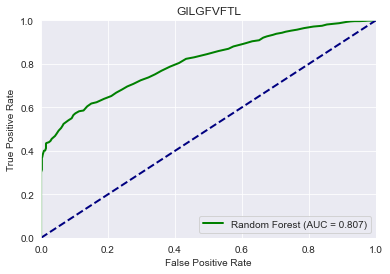

ROC AUC: 0.8074640808759632


In [6]:
from sklearn import metrics
from util import plot_roc_curve

predictions = model.predict_proba(val_X)
fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")

Predicting: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


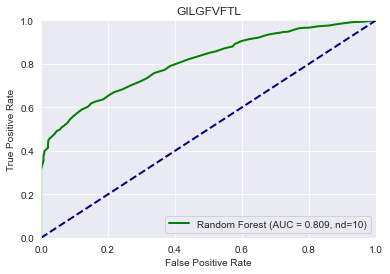

ROC AUC: 0.8087031458200568


Predicting: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


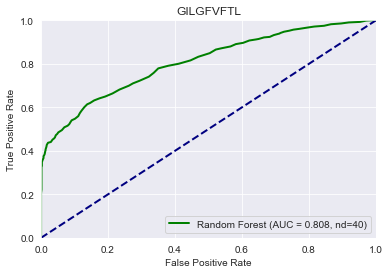

ROC AUC: 0.8079586930073577


Predicting: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


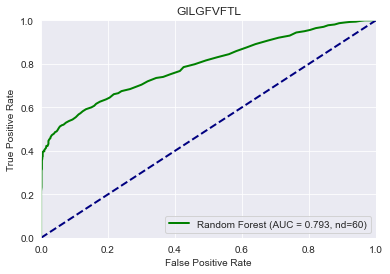

ROC AUC: 0.7928487631075836


Predicting: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


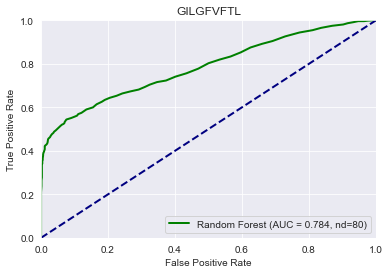

ROC AUC: 0.7844838074271479


Predicting: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


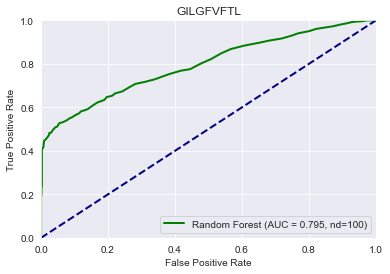

ROC AUC: 0.7950756039626904


In [9]:
for nan_distance in [10, 40, 60, 80, 100]:
    model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains,
                                      distance_kwargs={"nan_distance": nan_distance})
    model.fit(train_X, train_y)

    predictions = model.predict_proba(val_X)
    fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f}, nd={nan_distance})', title="GILGFVFTL")
    print(f"ROC AUC: {roc_auc}")

Predicting: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


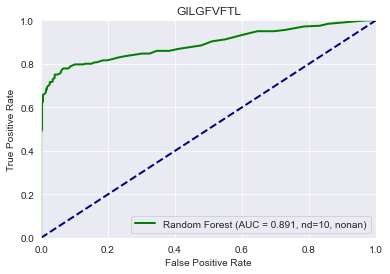

ROC AUC: 0.8908618899273105


In [11]:
# do the same, but without nan's in the validation dataset
val_df_no_nan = val_df.dropna()
val_X_no_nan = val_df_no_nan[['CDR3_alfa', 'CDR3_beta']].to_numpy()
val_y_no_nan = val_df_no_nan['reaction'].to_numpy()

# nan_distance doesn't matter here, because there are no nan's
for nan_distance in [10]:
    model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist_multiple_chains,
                                      distance_kwargs={"nan_distance": nan_distance})
    model.fit(train_X, train_y)

    predictions = model.predict_proba(val_X_no_nan)
    fpr, tpr, thresholds = metrics.roc_curve(val_y_no_nan, predictions[:, 1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f}, nd={nan_distance}, nonan)', title="GILGFVFTL")
    print(f"ROC AUC: {roc_auc}")



In [7]:
# Compare with performance of sklearn random forest with 100 trees and 1000 samples on the same columns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import \
    accuracy_score  # accuracy instead of auc, since the Pforest print_results only provides accuracy

from util import get_train_dataset, get_features, train_test_split, fix_test, get_test_dataset

df = get_train_dataset()
# df = df.sample(n=1000)
df = df[['CDR3_alfa', 'CDR3_beta', 'reaction']]

train, test = train_test_split(df, test_size=0.2, random_state=42)

y = train['reaction']
x = get_features(train, cdr_only=True)

x_test = get_features(test, test=True, cdr_only=True)
x_test = fix_test(x_test, x.columns)
y_test = test['reaction']

# change the nan values to 0
x = x.fillna(0)
x_test = x_test.fillna(0)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(x, y)
y_pred = clf.predict(x_test)

# get accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy val (100 trees, 1000 samples, zero-imputed, only CDR columns): {accuracy}")

df_test = get_test_dataset()
df_test = df_test[['CDR3_alfa', 'CDR3_beta', 'reaction']]
x_test = get_features(df_test, test=True, cdr_only=True)
x_test = fix_test(x_test, x.columns)
x_test = x_test.fillna(0)
y_test = df_test['reaction']

y_pred = clf.predict(x_test)

# get accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy test (100 trees, 1000 samples, zero-imputed, only CDR columns, test set): {accuracy}")

Accuracy val (100 trees, 1000 samples, zero-imputed, only CDR columns): 0.762936221419976
Accuracy test (100 trees, 1000 samples, zero-imputed, only CDR columns, test set): 0.7534906114588349


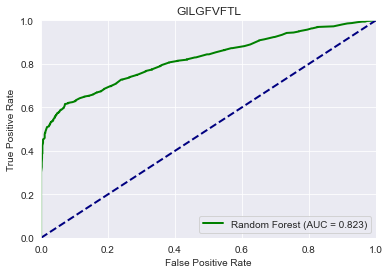

ROC AUC: 0.8230446606119965


In [14]:
# get the auc score
from sklearn import metrics
from util import plot_roc_curve

predictions_rf = clf.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")

In tcrdist ook V functie afstand

### CDR + V + J

Up to now, We've only used our CDR sequence. Let's see if we can improve our results by also using the V and J sequences.

#### Distance function


In [42]:
import tcrdist


def calculate_tcr_dist_2(seq1, seq2):
    pass


In [43]:
from util import get_train_dataset

df = get_train_dataset().dropna().head(10)
df = df[['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ']]
df

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ
2,CAFMKQRGGGADGLTF,TRAV38-1,TRAJ45,CASSISSGRGNEQFF,TRBV19,TRBJ2-1
3,CRNAGGTSYGKLTF,TRAV25,TRAJ52,CASSSHQRTGVDEQFF,TRBV27,TRBJ2-1
12,CAGASNTGKLIF,TRAV27,TRAJ37,CASSLGDNTEAFF,TRBV7-9,TRBJ1-1
13,CALDNVWDSGYALNF,TRAV6,TRAJ41,CASSLVPIGTDTQYF,TRBV12-3,TRBJ2-3
14,CAYRSARIGTASKLTF,TRAV38-2DV8,TRAJ44,CASRRIGRGGNQPQHF,TRBV19,TRBJ1-5
17,CATRLQGGSEKLVF,TRAV14DV4,TRAJ57,CASSLSRANLDTQYF,TRBV7-9,TRBJ2-3
19,CAGGSGGSQGNLIF,TRAV25,TRAJ42,CASSMRSTGELFF,TRBV19,TRBJ2-2
22,CAVRYFGMDSSYKLIF,TRAV8-6,TRAJ12,CASSLWDSEETQYF,TRBV12-3,TRBJ2-5
24,CAEDNNARLMF,TRAV5,TRAJ31,CASSSFLLSEQYF,TRBV19,TRBJ2-7
27,CALSGIGGSQGNLIF,TRAV16,TRAJ42,CASSTRSSYEQYF,TRBV19,TRBJ2-7


In [44]:
# rename the columns so they work with tcrdist
df = df.rename(columns={'CDR3_alfa': 'cdr3_a_aa',
                        'TRAV': 'v_a_gene',
                        'TRAJ': 'j_a_gene',
                        'CDR3_beta': 'cdr3_b_aa',
                        'TRBV': 'v_b_gene',
                        'TRBJ': 'j_b_gene'})

> For v_x_gene, include the full IMGT gene name and allele (e.g., TRBV1*01). If you don’t know the allele, use *01. But an allele must be present to infer v_b_genes based on matching one of the id rows in this table.

Add *01 to the gene names

In [45]:
for col in ['v_a_gene', 'v_b_gene', 'j_a_gene', 'j_b_gene']:
    df[col] = df[col].apply(lambda x: x + '*01')
    # Also replace 2DV8 with 2/DV8
    df[col] = df[col].apply(lambda x: x.replace('2DV8', '2/DV8'))
    df[col] = df[col].apply(lambda x: x.replace('14DV4', '14/DV4'))

In [46]:
import pandas as pd
from tcrdist.repertoire import TCRrep

In [47]:
# from tcrsampler.setup_db import install_all_next_gen
# install_all_next_gen(dry_run = False)

In [48]:
# tr = TCRrep(cell_df=df,  #(2)
#             df2=df2,
#             # organism='mouse',
#             chains=['alpha', 'beta'],
#             db_file='adaptive_imgt_mapping.csv'
#             )
# tr.compute_rect_distances()

That didn't work. When searching further in the code of tcrdist, I noticed the adaptive-imgtp_mapping.csv is only used in swap_gene_name.py file, so we probably need to swap those genes manually.

Howerver, we need IMGTP to adaptive (and not the other way around), so I'll use the adaptive_imgt_mapping.csv file to swap this manually.

In [49]:
# def swap_single_imgt_to_adaptive(imgt, swap_db):
#     assert imgt in swap_db['imgt'].values, f"imgt {imgt} not found in swap_db"
#     return swap_db[swap_db['imgt'] == imgt]['adaptive'].values[0]
#
# def swap_imgt_to_adaptive(df):
#     swap_db = pd.read_csv('data/adaptive_imgt_mapping.csv')
#     for col in ['v_a_gene', 'v_b_gene', 'j_a_gene', 'j_b_gene']:
#         df[col] = df[col].apply(lambda x: swap_single_imgt_to_adaptive(x, swap_db))

In [50]:
# swap_imgt_to_adaptive(df)

In [51]:
df = df.head(3)
df2 = df.tail(7)

In [0]:
tr = TCRrep(cell_df=df,  #(2)
            df2=df2,
            organism='human',
            chains=['alpha', 'beta'],
            db_file='alphabeta_gammadelta_db.tsv'
            )

In [66]:
tr.compute_distances()

In [67]:
# get the computed distances
tr.pw_alpha

array([[  0, 181, 163],
       [181,   0,  80],
       [163,  80,   0]], dtype=int16)

In [68]:
tr.pw_beta

array([[  0, 129, 118],
       [129,   0, 163],
       [118, 163,   0]], dtype=int16)

In [69]:
tr.pw_cdr3_a_aa

array([[ 0, 40, 36],
       [40,  0, 16],
       [36, 16,  0]], dtype=int16)

In [70]:
tr.pw_cdr3_b_aa

array([[ 0, 26, 27],
       [26,  0, 36],
       [27, 36,  0]], dtype=int16)

In [1]:
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep

def calculate_tcr_dist2(seq1, seq2, nan_distance=0):
    if (seq1 == seq2).all():
        return 0

    # create a dataframe with the two sequences

    # seq1 and seq2 are two rows in the tDataFrame
    # the columns are cdr3_a_aa, v_a_gene, j_a_gene, cdr3_b_aa, v_b_gene, j_b_gene

    df = pd.DataFrame([seq1, seq2], columns=['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene'])
    df['count'] = 1

    # contains the df a nan value?
    if df.isnull().values.any():
        return nan_distance

    # create a TCRrep object
    tr = TCRrep(cell_df=df,
                organism='human',
                chains=['alpha', 'beta'],
                db_file='alphabeta_gammadelta_db.tsv'
                )
    # compute the distances
    tr.compute_distances()
    # get the computed distances
    # return tr.pw_cdr3_a_aa[0][1], tr.pw_cdr3_b_aa[0][1] # TODO: normalize the distances
    # if pw_alpha is 1x1, return it's only value (probably 0) # todo: this is the case because the family is not recognized, must be fixed
    if tr.pw_alpha.shape == (1, 1):
        return tr.pw_alpha[0][0]
    return tr.pw_alpha[0][1] + tr.pw_beta[0][1] + tr.pw_cdr3_a_aa[0][1] + tr.pw_cdr3_b_aa[0][1]

In [11]:
# errors on e.g. TODO: ask
s1 = ['CAMSRPFITQGGSEKLVF', 'TRAV12-3*01', 'TRAJ57*01', 'CASSFLGGSEQYF', 'TRBV12-3*01', 'TRBJ2-7*01']
s2 = ['CAALRMDTGRRALTF', 'TRAV23DV6*01' ,'TRAJ5*01', 'CSARGRDPGQIFSYEQYF', 'TRBV20-1*01' ,'TRBJ2-7*01']
# create an ndarray (6,) from s1
s1 = np.array(s1)
# create an ndarray (6,) from s2
s2 = np.array(s2)

calculate_tcr_dist2(s1, s2)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:500: UserWarning: TRAV23DV6*01 gene was not recognized in reference db no cdr seq could be inferred
  f0 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:504: UserWarning: TRAV23DV6*01 gene was not recognized in reference db no cdr seq could be inferred
  f1 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:508: UserWarning: TRAV23DV6*01 gene was not recognized in reference db no cdr seq could be inferred
  f2 = lambda v : self._map_gene_to_reference_seq2(gene = v,
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\tcrdist\repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.1 of 2 were not captured. This occurs when any of the values in the in

0.0

#### Performance

In [5]:
from util import get_train_dataset, ProximityTreeClassifier, calculate_tcr_dist_multiple_chains
from sklearn.model_selection import train_test_split

x_columns = ['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ']
# x_columns = ['CDR3_alfa', 'CDR3_beta']
y_column = 'reaction'

df = get_train_dataset()
df = df[x_columns + [y_column]]
df = df.sample(100)

for col in ['TRAV', 'TRAJ', 'TRBV', 'TRBJ']:
    # only append if not nan
    df[col] = df[col].apply(lambda x: x + '*01' if not pd.isna(x) else x)

    # df[col] = df[col].apply(lambda x: x.replace('2DV8', '2/DV8'))
    # df[col] = df[col].apply(lambda x: x.replace('14DV4', '14/DV4'))

    # only if not nan
    df[col] = df[col].apply(lambda x: x.replace('2DV8', '2/DV8') if not pd.isna(x) else x)
    df[col] = df[col].apply(lambda x: x.replace('14DV4', '14/DV4') if not pd.isna(x) else x)
    # TRAV23DV6
    df[col] = df[col].apply(lambda x: x.replace('23DV6', '23/DV6') if not pd.isna(x) else x)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# create numpy arrays for the train and test data
train_X = train_df[x_columns].to_numpy()
train_y = train_df[y_column].to_numpy()

val_X = val_df[x_columns].to_numpy()
val_y = val_df[y_column].to_numpy()

In [6]:
from util import ProximityForestClassifier
from sklearn.metrics import accuracy_score

model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2,
                                  distance_kwargs={"nan_distance": 0}, multithreaded=False)
model.fit(train_X, train_y)

predictions = model.predict(val_X)

accuracy_score(val_y, predictions)

Fitting:   1%|          | 1/100 [16:03<26:29:00, 963.04s/it]


KeyboardInterrupt: 

In [ ]:
from sklearn import metrics
from util import plot_roc_curve

predictions = model.predict_proba(val_X)
fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")